In [37]:
from polymer import *
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [38]:
def bin_index(x, bin_edges):

    bin_range = bin_edges[-1] - bin_edges[0]
    bin_pos = x - bin_edges[0]

    return int( (bin_pos/bin_range)*(len(bin_edges)-1.0) )

In [39]:
def ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, run_temperature, target_temperature):

    weights = np.zeros(len(energy_samples))

    for isamp, energy in enumerate(energy_samples):
        ibin = bin_index(energy, bin_edges)
        bias = old_bias[ibin]
        weights[isamp] = m.exp((bias+energy)/run_temperature)*m.exp(-energy/target_temperature)
        
    # Calculate the probability distribution 
    counts, bins = np.histogram(energy_samples,bins=bin_edges,weights=weights,density=True)

    return counts, bins

In [40]:
def update_muca_bias(energy_samples, old_bias, bin_edges, bin_width, temperature):


    print(old_bias)
    
    # Calculate the probability distribution from the samples given
    counts, bins = np.histogram(energy_samples,bins=bin_edges,density=True)

    print(np.max(counts))

    mincount = np.min(counts[counts > 0.0])
    counts = [ max(count,mincount) for count in counts]
    print(counts)
    increments = [ temperature * m.log(count) for count in counts ]
    increments = np.asarray(increments)
    
    print(len(old_bias))
    
    new_bias = old_bias + increments

    print(len(new_bias))

    #from scipy.signal import savgol_filter
    #new_bias = savgol_filter(new_bias, 9, 3) # window size 51, polynomial order 3
    
    min_bias = min(new_bias)
    new_bias = [bias - min_bias for bias in new_bias]




    return new_bias


In [41]:
def run_muca_sweeps(chain, bin_edges, bias, Nsweeps=100, max_disp=0.15, temperature=0.2, sample_int=100):
    """ Runs Nsweeps MC sweeps where one sweep is on average at attempt to move each mobile bead on the chain at least once.
        Returns a  """

    # Store inverse temperature
    beta = 1.0/temperature

    # Initialise sampling for the current set of sweeps
    samples = []
    acount  = 0

    old_energy = chain.energy()
    
    for itrial in range(Nsweeps*(chain.Nbeads-1)):

        # Randomly choose any bead but the first
        ibead = np.random.randint(1,chain.Nbeads) # first bead never moves

        disp = 2.0*np.random.random_sample(2)-1.0
        disp = disp*max_disp

        old_local_energy = chain.local_energy(ibead)
        
        ibin = bin_index(old_energy, bin_edges)
        old_bias = bias[ibin]
        
        chain.rpos[ibead] = chain.rpos[ibead] + disp
    
        new_local_energy = chain.local_energy(ibead)

        new_energy = old_energy + ( new_local_energy - old_local_energy )
        jbin = bin_index(new_energy, bin_edges)
        


        if jbin in range (0, len(bias)):

            new_bias = bias[jbin]
        
            diff_energy = (new_energy + new_bias) - (old_energy + old_bias)
            

            if np.random.sample() < m.exp(-diff_energy*beta):
                # accepted
                acount = acount + 1
                old_energy = new_energy
            else:
                # reject and reset
                chain.rpos[ibead] = chain.rpos[ibead] - disp

        else:
            # reject and reset
            chain.rpos[ibead] = chain.rpos[ibead] - disp
        

        if itrial%sample_int*(chain.Nbeads-1)==0:
            samples.append((chain.energy(), chain.end2end()))

    return chain, samples, acount/(Nsweeps*(chain.Nbeads-1))    

Starting sampling from bin  29
Number of bins :  50
[-6.1   -5.898 -5.696 -5.494 -5.292 -5.09  -4.888 -4.686 -4.484 -4.282
 -4.08  -3.878 -3.676 -3.474 -3.272 -3.07  -2.868 -2.666 -2.464 -2.262
 -2.06  -1.858 -1.656 -1.454 -1.252 -1.05  -0.848 -0.646 -0.444 -0.242
 -0.04   0.162  0.364  0.566  0.768  0.97   1.172  1.374  1.576  1.778
  1.98   2.182  2.384  2.586  2.788  2.99   3.192  3.394  3.596  3.798
  4.   ]
0
49
50


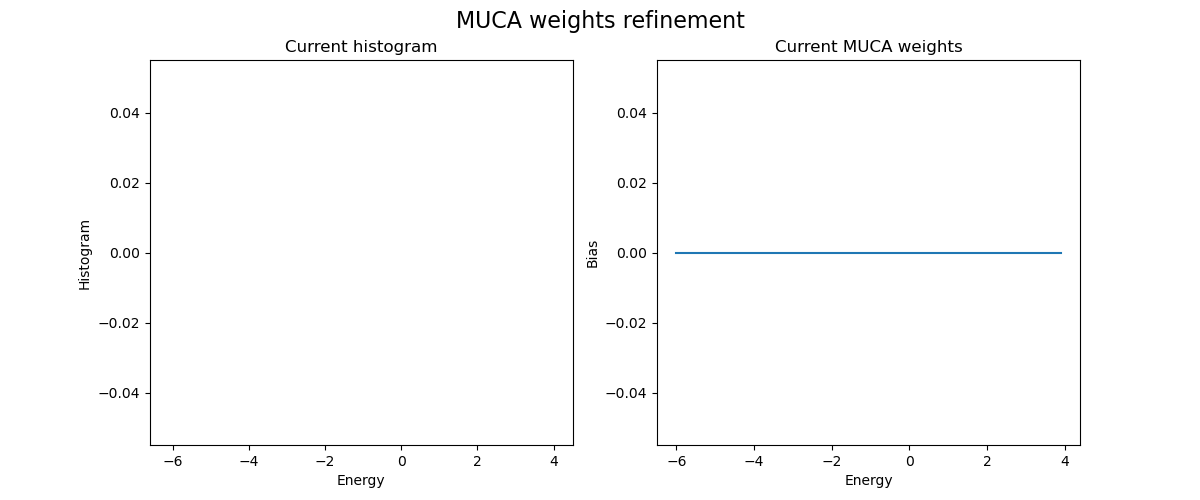

In [42]:
# Initialise muca simulation

Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

print("Starting sampling from bin ", bin_index(chain.energy(), bin_edges))

old_bias = np.zeros(len(bin_edges)-1)
muca_hist = np.zeros(len(bin_edges)-1)

print("Number of bins : ", len(muca_hist))

print(bin_edges[:])



print(bin_index(-6.04,bin_edges))
print(bin_index(3.8,bin_edges))

print(bin_index(4.1,bin_edges))

# Setup some plots
%matplotlib widget
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(bin_edges[:-1], muca_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
ax1.set_xlabel('Energy')
ax2.set_xlabel('Energy')
ax1.set_ylabel('Histogram')
ax2.set_ylabel('Bias')
fig.suptitle('MUCA weights refinement', fontsize=16)
ax1.set_title('Current histogram')
ax2.set_title('Current MUCA weights')
plt.show()


In [43]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4

Ncycles=10

for icyc in range(Ncycles):

    Nframes = 1000
    f = IntProgress(min=0, max=Nframes) # instantiate the bar
    samples = []

    muca_hist = np.zeros(len(bin_edges)-1)

    display(f) # display the bar
    fig.canvas.draw()
    fig.canvas.flush_events()

    for iframe in range(Nframes):

        chain, new_samples, ratio = run_muca_sweeps(chain, bin_edges, old_bias, Nsweeps=100, max_disp=0.1, temperature=temp, sample_int = 100)
        samples += new_samples
        f.value +=1  # Increment progress bar

        energy_samples  = [ sample[0] for sample in samples ]
        counts, bins = np.histogram(energy_samples, bins=bin_edges)

        # Setup some plots
        ax1.cla(), ax2.cla()
        ax1.bar(bin_edges[:-1], counts,   width=bin_width,align='edge')
        ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
        ax1.set_xlabel('Energy')
        ax2.set_xlabel('Energy')
        ax1.set_ylabel('Histogram')
        ax2.set_ylabel('Bias')
        fig.suptitle('MUCA weights refinement', fontsize=16)
        ax1.set_title('Current histogram')
        ax2.set_title('Current MUCA weights')
        plt.draw()
    
        fig.canvas.draw()
        fig.canvas.flush_events()

    print("Accepted ",round(ratio*100,2),"% of trial moves")

    #new_bias = update_muca_bias(energy_samples, old_bias, bin_edges, bin_width, temp)
    #old_bias = new_bias

    counts, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, temp)

    mincount = np.min(counts[counts > 0.0])
    counts = [ max(count,mincount) for count in counts]
    new_bias = [ temp * m.log(count) for count in counts ]
    new_bias = np.asarray(new_bias)
    
    min_bias = min(new_bias)
    new_bias = [bias - min_bias for bias in new_bias]

    old_bias = new_bias    
    
    filename = "muca_bias_N"+str(Nbeads)+"T"+str(temp)+"_cycle_"+str(icyc)+".txt"
    np.savetxt(filename, old_bias)



IntProgress(value=0, max=1000)

Accepted  59.83 % of trial moves


IntProgress(value=0, max=1000)

Accepted  33.17 % of trial moves


IntProgress(value=0, max=1000)

KeyboardInterrupt: 

In [ ]:
print(old_bias)

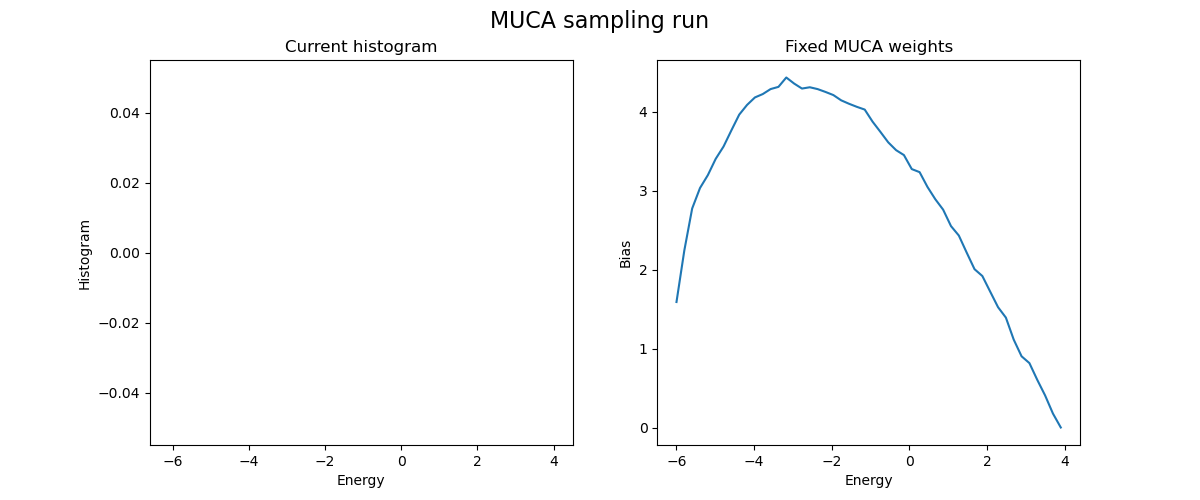

In [7]:
# Initialise muca simulation with constant weights 

Ndims=2 ; Nbeads=7
chain = polymer(Ndims = Ndims, Nbeads = Nbeads)

# Define energy range and bins
energy_range = [-6.1, 4.0]
bin_edges = np.histogram_bin_edges(energy_range, bins=50)
bin_width = bin_edges[1] - bin_edges[0]

# Load MUCA weights I made earlier
filename = 'muca_bias_N7T0.4_cycle_9.txt'
old_bias = np.loadtxt(filename)
muca_hist = np.zeros(len(bin_edges)-1)

# Setup some plots
%matplotlib widget
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(bin_edges[:-1], muca_hist,   width=bin_width,align='edge')
ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
ax1.set_xlabel('Energy')
ax2.set_xlabel('Energy')
ax1.set_ylabel('Histogram')
ax2.set_ylabel('Bias')
fig.suptitle('MUCA sampling run', fontsize=16)
ax1.set_title('Current histogram')
ax2.set_title('Fixed MUCA weights')
plt.show()

In [12]:
from ipywidgets import IntProgress
from IPython.display import display
import time

temp = 0.4

Nframes = 500
f = IntProgress(min=0, max=Nframes) # instantiate the bar
samples = []

display(f) # display the bar
fig.canvas.draw()
fig.canvas.flush_events()

for iframe in range(Nframes):

    chain, new_samples, ratio = run_muca_sweeps(chain, bin_edges, old_bias, Nsweeps=100, max_disp=0.1, temperature=temp, sample_int = 100)
    samples += new_samples
    f.value +=1  # Increment progress bar

    energy_samples  = [ sample[0] for sample in samples ]
    counts, bins = np.histogram(energy_samples, bins=bin_edges)

    # Setup some plots
    ax1.cla(), ax2.cla()
    ax1.bar(bin_edges[:-1], counts,   width=bin_width,align='edge')
    ax2.plot(bin_edges[:-1]+0.5*bin_width, old_bias)
    ax1.set_xlabel('Energy')
    ax2.set_xlabel('Energy')
    ax1.set_ylabel('Histogram')
    ax2.set_ylabel('Bias')
    fig.suptitle('MUCA sampling run', fontsize=16)
    ax1.set_title('Current histogram')
    ax2.set_title('Fixed MUCA weights')
    plt.draw()
    
    fig.canvas.draw()
    fig.canvas.flush_events()

print("Accepted ",round(ratio*100,2),"% of trial moves")

filename = 'samples_N7T0.4_cycle_9.dat'
FILE = open(filename,"w")
np.asarray(samples).tofile(FILE)
FILE.close()


IntProgress(value=0, max=500)

Accepted  67.67 % of trial moves


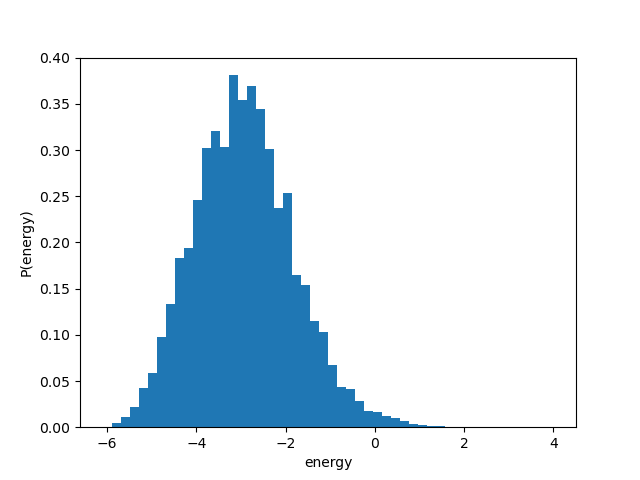

In [36]:
#Energy at some particular temperature 
energy_samples  = [ sample[0] for sample in samples ]

new_temp = 0.4

counts, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, new_temp)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1],counts,width=bin_width,align='edge')
ax.set_xlabel('energy')
ax.set_ylabel('P(energy)')
plt.show()

Mean energy at temperature  0.1  =  -5.713986042949795
Mean energy at temperature  0.11  =  -5.6512431864969725
Mean energy at temperature  0.12  =  -5.583674755068565
Mean energy at temperature  0.13  =  -5.511234442644376
Mean energy at temperature  0.13999999999999999  =  -5.433938031946287
Mean energy at temperature  0.14999999999999997  =  -5.351884288333825
Mean energy at temperature  0.15999999999999998  =  -5.26526097281633
Mean energy at temperature  0.16999999999999998  =  -5.17433958492569
Mean energy at temperature  0.17999999999999997  =  -5.079465690758856
Mean energy at temperature  0.18999999999999995  =  -4.9810500991775735
Mean energy at temperature  0.19999999999999996  =  -4.879562243776577
Mean energy at temperature  0.20999999999999996  =  -4.7755238877619295
Mean energy at temperature  0.21999999999999995  =  -4.669500170359579
Mean energy at temperature  0.22999999999999993  =  -4.56208594505477
Mean energy at temperature  0.23999999999999994  =  -4.453887313186

Text(0, 0.5, '<E>')

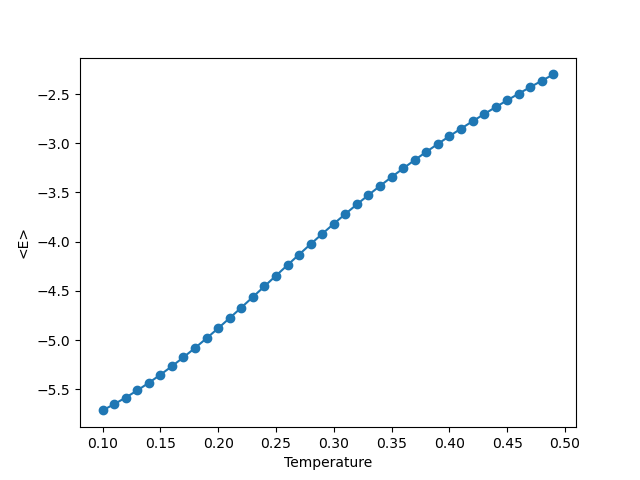

In [28]:
# Something more sophisticated

temperatures = np.arange(0.1,0.5,0.01)

mean_energies = np.zeros(len(temperatures))

for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp

    prob, bins = ubiased_histogram(energy_samples, old_bias, bin_edges, bin_width, temp, new_temp)

    # Mean energy
    mean_energy = np.dot(bin_edges[:-1]+0.5*bin_width,prob)/np.sum(prob)
    print("Mean energy at temperature ", new_temp, " = ",mean_energy)
    mean_energies[itemp] = mean_energy

fig, ax = plt.subplots()
plt.plot(temperatures, mean_energies,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<E>')


In [29]:
# Do something with the samples
energy_samples  = [ sample[0] for sample in samples ]
end2end_samples = [ sample[1] for sample in samples ]

Text(0, 0.5, '<L>')

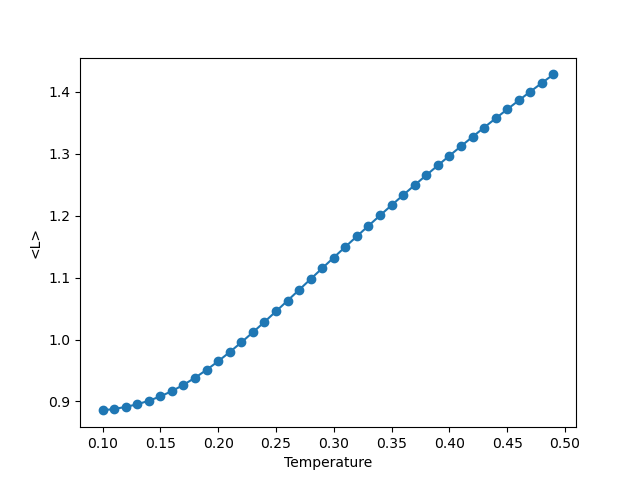

In [33]:
# End to end distance as a function of temperature
temperatures = np.arange(0.1,0.5,0.01)

mean_end2end = np.zeros(len(temperatures))

weights = np.zeros(len(energy_samples))

for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        #bin_energy = edge + 0.5*bin_width
        #weights[isamp] = m.exp(wl_logdos[ibin]-beta*bin_energy)#/wl_hist[ibin]
        bias = old_bias[ibin]
        weights[isamp] = m.exp((bias+sample_energy)/temp)*m.exp(-sample_energy/new_temp)
    
    # Mean end to end distance
    mean_end2end[itemp] = np.dot(end2end_samples, weights)/np.sum(weights)
    #print("Mean end to end distance at temperature ", temperature, " = ",mean_end2end[itemp])

fig, ax = plt.subplots()
plt.plot(temperatures, mean_end2end,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<L>')

0.1 6.074008305668135
0.11 6.519300596895869
0.12 6.986839209723261
0.13 7.467518944110906
0.13999999999999999 7.950397482460743
0.14999999999999997 8.423787176586977
0.15999999999999998 8.876586404828277
0.16999999999999998 9.299090154722446
0.17999999999999997 9.683112925989722
0.18999999999999995 10.021723313895468
0.19999999999999996 10.308993780106459
0.20999999999999996 10.54001343042475
0.21999999999999995 10.711180626247543
0.22999999999999993 10.820624907405701
0.23999999999999994 10.86855760048698
0.24999999999999994 10.857399652446285
0.2599999999999999 10.791631212775968
0.2699999999999999 10.677398824091355
0.2799999999999999 10.521972328205777
0.2899999999999999 10.33315839474617
0.29999999999999993 10.11876097179369
0.3099999999999999 9.886146881243484
0.3199999999999999 9.641941194177047
0.3299999999999999 9.39185039940086
0.33999999999999986 9.14059472238324
0.34999999999999987 8.891923527940246
0.3599999999999999 8.648687066638123
0.3699999999999999 8.412941140355535


Text(0, 0.5, '<Cv>')

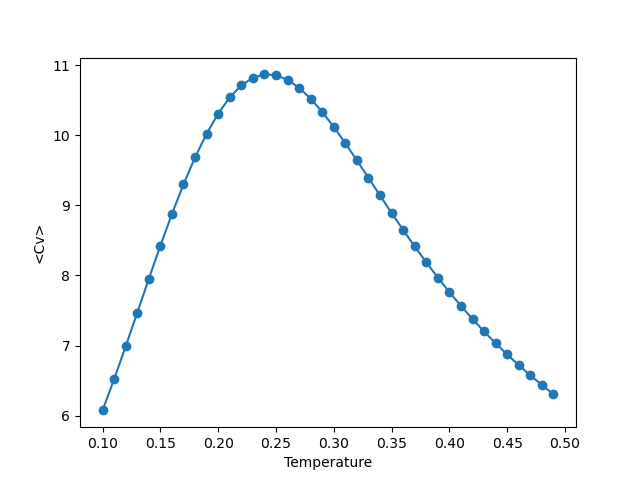

In [34]:
# Heat capacity as a function of temperature
temperatures = np.arange(0.1,0.5,0.01)

heat_cap = np.zeros(len(temperatures))

#energy_sq_samples = [energy**2 for energy in energy_samples]

for itemp, new_temp in enumerate(temperatures):
    
    beta = 1.0/new_temp
    prob = np.zeros(len(bin_edges)-1)

    for isamp, sample_energy in enumerate(energy_samples):

        ibin = bin_index(sample_energy, bin_edges)
        edge = bin_edges[ibin]
        bin_energy = edge + 0.5*bin_width
        bias = old_bias[ibin]
        weights[isamp] = m.exp((bias+sample_energy)/temp)*m.exp(-sample_energy/new_temp)

    

    mean_energy = np.dot(energy_samples,weights)/np.sum(weights)
    delta_energy_sq = [(energy - mean_energy)**2 for energy in energy_samples]
    mean_deltaE_sq = np.dot(delta_energy_sq ,weights)/np.sum(weights)
    
    heat_cap[itemp] = mean_deltaE_sq/(new_temp**2) #+ (Ndims/2)*(Nbeads-1)

    print(new_temp, heat_cap[itemp])

fig, ax = plt.subplots()
plt.plot(temperatures, heat_cap,'o-')
ax.set_xlabel('Temperature')
ax.set_ylabel('<Cv>')

In [35]:
T_trans = temperatures[np.argmax(heat_cap)]; print(T_trans)

0.23999999999999994
